# Practice Session on Nonnegative Matrix Factorization (NMF)
## 1 - Derivation of $\beta$-divergence (stochastic coordinate descent)

We roughly talk about the $\beta$-divergence $\beta \in [0,2]$ which is defined as follow:

$$
d_\beta(x,y) =
\begin{cases}
\frac{1}{\beta(\beta-1)}(x^\beta + (\beta - 1)y^\beta - \beta x y^{\beta-1}) & \beta \in \mathbb{R} \backslash \{0,1\} \\
x\log(\frac{x}{y}) - x + y  & \beta = 1  \text{ (Kullback-Leibler Divergence)}\\
\frac{x}{y}  - \log (\frac{x}{y}) - 1 & \beta=0 \text{ (Itakura-Saito)}
\end{cases}
$$

We consider $v_{ft}$ the power spectrogram coefficient for the TF bin $(f,t)$ and its NMF approximation:
$$
v_{ft} \approx \sum_{k=1}^{K} w_{fk}h_{kt}
$$
where $K$ is the latent dimension. Defining $V=\{v_{ft}\}_{f,t=1}^{F,T} \in \mathbb{R}^{F \times T}_{+}, W=\{w_{fk}\}_{f,k=1}^{F,K} \in \mathbb{R}^{F \times K}_{+}, H=\{h_{kt}\}_{k,t=1}^{K,T} \in \mathbb{R}^{K \times T}_{+}$ we also have:

$$
V \approx WH
$$

We aim to minimize $d_{\beta}(V \mid WH) = \sum_{f,t = 1}^{F,T} d_{\beta}(v_{ft} \mid \sum_{k=1}^{K} w_{fk}h_{kt}) $.

1. As we did this morning, compute $\frac{\partial d_{\beta}(V \mid WH)}{\partial w_{fk}}$ and $\frac{\partial d_{\beta}(V \mid WH)}{\partial h_{kt}}$

2. Express The coordinate descent version in the scalar mode (*i.e.* $w_{fk}^{(i+1)} \leftarrow w_{fk}^{(i)} - \eta \frac{\partial d_{\beta}(V \mid WH)}{\partial w_{fk}}$)


###Answer : for $\beta = 1$


$\frac{\partial d_{\beta}(V \mid WH)}{\partial w_{fk}} = \sum_{t=1}^{T} (\frac{-v_{ft}}{\sum_{k'=1}^{K}w_{fk'}h_{k't}}+1)h_{kt} $


$\frac{\partial d_{\beta}(V \mid WH)}{\partial h_{kt}} = \sum_{f=1}^{F} (\frac{-v_{ft}}{\sum_{k'=1}^{K}w_{fk'}h_{k't'}}+1)w_{fk} $


$w_{fk}^{(i+1)} \leftarrow w_{f,k}^{(i)} - \eta \sum_{t=1}^{T} (\frac{-v_{ft}}{\sum_{k'=1}^{K}w_{fk'}h_{k't}}+1)h_{kt} $


## 2 - $\beta$-NMF with Multiplicative update Rules
Let's find an auxiliary function easier to derive. Meaning a function $\mathcal{L}(V,W,H, \Theta)$ such that:
$$
d_{\beta}(V \mid WH) \leq \mathcal{L}(V,W,H, \Lambda, Z) \\
d_{\beta}(V \mid WH) = \mathcal{L}(V,W,H, \tilde{\Lambda}, \tilde{Z})
$$

We will proceed to the auxiliary function only for $\beta<1$. It can be shown that:

$$
d_{\beta}(V \mid WH)\leq\sum_{f,t=1}^{F,T}\frac{v_{ft}}{\beta\left(\beta-1\right)}+\sum_{f,t=1}^{F,T}\left[z_{ft}^{\beta-1}\left(\hat{v}_{ft}-z_{ft}\right)+\frac{z_{ft}^{\beta}}{\beta}-\frac{v_{ft}}{\beta}\sum_{k=1}^{K}\lambda_{ftk}\left(\frac{w_{fk}h_{kt}}{\lambda_{ftk}}\right)^{\beta}\right]\\\
\triangleq\mathcal{L}\left(V,W,H,\Lambda,Z\right)
$$

1. Derive $\mathcal{L}$ with respect to $w_{fk}$ and $h_{kt}$ and show that setting the gradient to zero yields:
$w_{fk}^{2-\beta}=\frac{\sum_{t=1}^{T}v_{ft}\lambda_{ftk}^{2-\beta}h_{kt}^{\beta-1}}{\sum_{t=1}^{T}z_{ft}^{\beta-1}h_{kt}}, h_{kt}^{2-\beta}=\frac{\sum_{t=1}^{T}v_{ft}\lambda_{ftk}^{2-\beta}w_{fk}^{\beta-1}}{\sum_{t=1}^{T}z_{ft}^{\beta-1}w_{fk}}$
1. $\mathcal{L}$ and $d_\beta$ are equal when $\lambda_{ftk}=\frac{w_{fk}h_{kt}}{\sum_{k^{\prime}}w_{fk^{\prime}}h_{k^{\prime}t}},z_{ft}=\sum_{k^{\prime}}w_{fk}h_{kt}$. Using those constraints, show the final multiplicative update rules:
$$
w_{fk} =w_{fk}\left(\frac{\sum_{t=1}^{T}v_{ft}\left(\sum_{k^{\prime}}w_{fk^{\prime}}h_{k^{\prime}t}\right)^{\beta-2}h_{kt}}{\sum_{t=1}^{T}\left(\sum_{k^{\prime}}w_{fk^{\prime}}h_{k^{\prime}t}\right)^{\beta-1}h_{kt}}\right)^{\frac{1}{2-\beta}}\\
h_{kt}  =h_{kt}\left(\frac{\sum_{f=1}^{F}v_{ft}\left(\sum_{k^{\prime}}w_{fk^{\prime}}h_{k^{\prime}t}\right)^{\beta-2}w_{fk}}{\sum_{f=1}^{F}\left(\sum_{k^{\prime}}w_{fk^{\prime}}h_{k^{\prime}t}\right)^{\beta-1}w_{fk}}\right)^{\frac{1}{2-\beta}}
$$
1. Implement the MUR code and play with all the parameters ($0 <\beta <1$, NFFT, $K$ etc.)

(513, 9) (9, 1729)


/tmp/ipykernel_96548/2989324282.py:32: RuntimeWarning: divide by zero encountered in log
  axs[1, 1].imshow(np.log(V), origin="lower", aspect="auto")


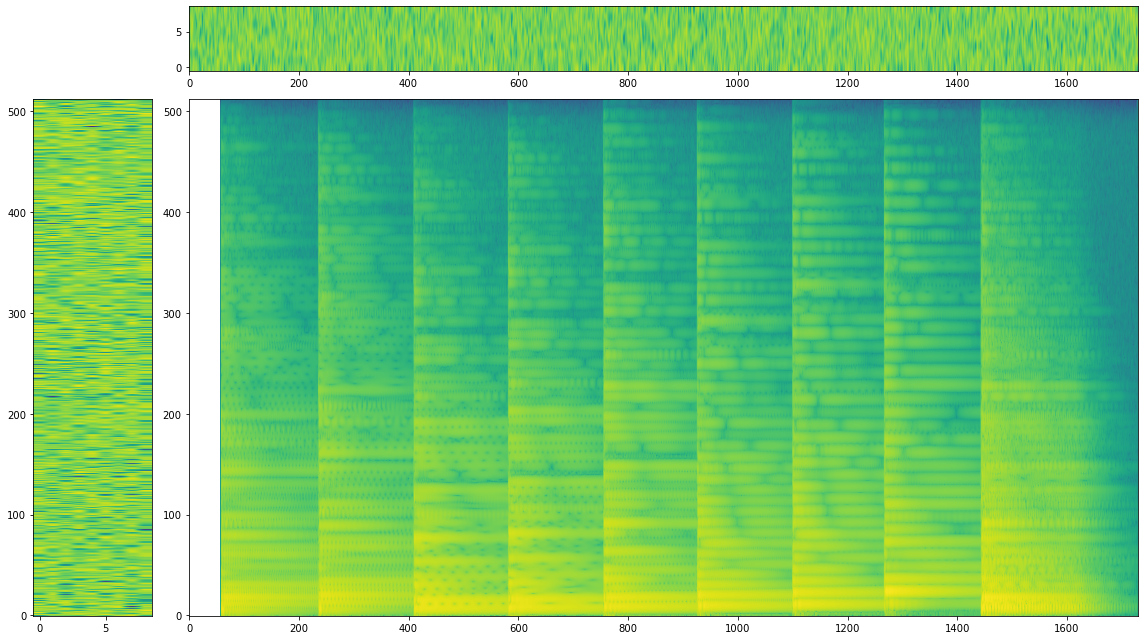

In [ ]:
import numpy as np
import librosa as lib
import scipy.signal as sig

import matplotlib.pyplot as plt

K=9 # latent space dim
NFFT = 1024 # number of point for FFT
y, sr = lib.load("Cmajor_piano.wav")

f,t, Y = sig.stft(y, sr, nfft=1024)
V = np.abs(Y) ** 2
nb_it = 5000 #  gradient descent
eta = 1e-2
beta = 1.2

eps = 1e-10 #under that value the entries of W are set to eps


W =  np.abs(np.random.randn(f.shape[0], K))
H =  np.abs(np.random.randn(K, t.shape[0]))
print(W.shape, H.shape)
V_hat = W @ H
###### TO COMPLETE#########
for l in range(nb_it):
    test=0
##### end to complete #
fig, axs = plt.subplots(2,2, figsize=(16,9), gridspec_kw={'height_ratios': [1, 8], 'width_ratios':[1, 8]})
fig.delaxes(axs[0,0])
axs[0,1].imshow(np.log(H + 2*eps), origin="lower", aspect="auto", interpolation="quadric")
axs[1,0].imshow(np.log(W + 2*eps), origin="lower", aspect="auto")
axs[1, 1].imshow(np.log(V), origin="lower", aspect="auto")

fig.tight_layout()
plt.show()

4. When you see a "nice" decomposition of $W$ and $H$ try to use them in order to separate each notes. 
i.e. as we saw this morning
$x_{kft} = x_{ft} \frac{w_{fk}h_{kt}}{\sum_{k^\prime = 1}^{K}w_{fk^\prime}h_{k^\prime t}}$

In [ ]:
# Use Wiener filtering to reconstruct each note separately


# Example reconstruction
y_hat_k = sig.istft(X_k_stft)
ipd.Audio(y_hat_k, rate=sr)
